# Vertex AI Prediction Endpoints for Online Forecasting With Prophet

Sometimes forecasting needs to be done in the moment to support applications like anomaly detection.  These are near real-time requirements where a given recent time-series can be used to train a forecast model that is used to predict the near-future.  The predictions can be used as baselines for the expected range of behavior for a process that is monitored. The process can then be flagged if it deviates from this forecasted expectaiton.  

Most forecasting techniques are done in batch.  For this application an online training and serving application needs to be built.  

The workflow:
- Build Forecasting Code with Prophet
- Build A Custom Prediction Routine that runs the forecasting code
- Deploy the Custom Prediction Routine to a Vertex AI Online Endpoint
- Get Forecast on-demand
- Test Scaling The Serving of forecast

In [1]:
!gcloud services enable artifactregistry.googleapis.com

In [7]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 46.8 MB/s eta 0:00:00


---
## Setup

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'vertexaiproject-454121'

In [3]:
REGION = 'us-central1'
EXPERIMENT = 'online-prophet'
SERIES = 'applied-forecasting'

In [4]:
BQ_REGION = REGION[0:2]

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

In [5]:
REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}"

In [8]:
import os
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import aiplatform
from google.cloud import artifactregistry_v1
from prophet import Prophet
import bigframes.pandas as bf

In [9]:
aiplatform.init(project = PROJECT_ID, location = REGION)
ar_client = artifactregistry_v1.ArtifactRegistryClient()

bf.reset_session()
bf.options.bigquery.project = BQ_PROJECT
bf.options.bigquery.location = BQ_REGION

In [10]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'918019863602-compute@developer.gserviceaccount.com'

In [11]:
DIR = f'temp/{EXPERIMENT}'
!rm -rf {DIR}
!mkdir -p {DIR}

In [12]:
df = bf.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}")

Use Pandas methods to evaluate the dataframe:

In [13]:
df.shape

(4382, 8)

In [14]:
df.dtypes

start_station_name         string[pyarrow]
starttime             date32[day][pyarrow]
num_trips                            Int64
avg_tripduration                   Float64
pct_subscriber                     Float64
ratio_gender                       Float64
capacity                             Int64
splits                     string[pyarrow]
dtype: object

Get a list of unique station names:

In [15]:
stations = df['start_station_name'].unique().tolist()
stations

['Central Park S & 6 Ave',
 'W 82 St & Central Park West',
 'Central Park West & W 76 St',
 'Grand Army Plaza & Central Park S',
 'Central Park West & W 72 St',
 'Central Park West & W 85 St',
 'Central Park West & W 100 St',
 'Central Park W & W 96 St',
 'Central Park West & W 102 St',
 'W 106 St & Central Park West',
 'Central Park North & Adam Clayton Powell Blvd',
 'Central Park West & W 68 St']

Review a single time series:

In [16]:
df[df['start_station_name'] == stations[0]].sort_values(by = ['starttime'])

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits
1628,Central Park S & 6 Ave,2013-07-01,69,1532.144928,0.652174,1.464286,73,TRAIN
4063,Central Park S & 6 Ave,2013-07-02,180,1817.505556,0.327778,0.363636,73,TRAIN
1227,Central Park S & 6 Ave,2013-07-03,115,1615.504348,0.4,0.455696,73,TRAIN
1354,Central Park S & 6 Ave,2013-07-04,175,2225.331429,0.297143,0.241135,73,TRAIN
2435,Central Park S & 6 Ave,2013-07-05,195,2213.061538,0.215385,0.203704,73,TRAIN
3245,Central Park S & 6 Ave,2013-07-06,222,1812.40991,0.18018,0.168421,73,TRAIN
3680,Central Park S & 6 Ave,2013-07-07,266,1942.007519,0.214286,0.1875,73,TRAIN
7,Central Park S & 6 Ave,2013-07-08,143,2368.783217,0.328671,0.361905,73,TRAIN
3159,Central Park S & 6 Ave,2013-07-09,148,1942.959459,0.554054,0.741176,73,TRAIN
923,Central Park S & 6 Ave,2013-07-10,142,1868.626761,0.514085,0.690476,73,TRAIN


---
## Prepare Data For Prophet

Prophet [expects a dataframe](https://facebook.github.io/prophet/docs/quick_start.html#python-api) for a single time series with columns `ds` for timestamp and `y` for the demand variable of the forecast. This data has multiple series, one for each station identified in the column `start_station_name`. Below is the code to create a dataframe for a given `start_station_name`.

In [17]:
stations[0]

'Central Park S & 6 Ave'

In [18]:
ts = df[(df['start_station_name'] == stations[0])][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds'])

In [19]:
ts.head()

,ds,y
1628,2013-07-01,69
4063,2013-07-02,180
1227,2013-07-03,115
1354,2013-07-04,175
2435,2013-07-05,195


Move a copy of the prepared data in `ts` to a local Pandas dataframe with `to_pandas()` method.

In [20]:
local_ts = ts.to_pandas()

In [21]:
type(ts), type(local_ts)

(bigframes.dataframe.DataFrame, pandas.core.frame.DataFrame)

---
## Create Forecast Model For Single Time Series - Locally (In Notebook)

Fit with [seasonality](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities) and [country holidays](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#built-in-country-holidays) added:

In [22]:
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
p.add_country_holidays(country_name='US')
p.fit(local_ts.iloc[0:-10])

15:57:42 - cmdstanpy - INFO - Chain [1] start processing
15:57:42 - cmdstanpy - INFO - Chain [1] done processing


Make dataframe for forecast by adding periods to the known date range of the training data. If you only want the forecast horizone then use the option `include_history = False`.

In [23]:
future = p.make_future_dataframe(periods = 10, include_history = False)
future.head()

,ds
0,2016-09-21
1,2016-09-22
2,2016-09-23
3,2016-09-24
4,2016-09-25


Generate the predictions for the forecast horizon. Since we kept the default that include the training history dates, we also get fit information for each of these dates.

In [24]:
forecast = p.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-21,205.363609,195.776762,356.089939,205.363609,205.363609,0.0,0.0,0.0,0.0,...,-26.265590,-26.265590,-26.265590,67.612301,67.612301,67.612301,0.0,0.0,0.0,276.215619
1,2016-09-22,205.542889,191.238681,349.273340,205.542889,205.542889,0.0,0.0,0.0,0.0,...,-27.763628,-27.763628,-27.763628,63.322679,63.322679,63.322679,0.0,0.0,0.0,270.607239
2,2016-09-23,205.722169,205.972511,355.614311,205.722169,205.722169,0.0,0.0,0.0,0.0,...,-14.947044,-14.947044,-14.947044,59.042556,59.042556,59.042556,0.0,0.0,0.0,279.322979
3,2016-09-24,205.901449,266.695908,419.429020,205.901449,205.901449,0.0,0.0,0.0,0.0,...,52.391135,52.391135,52.391135,54.832081,54.832081,54.832081,0.0,0.0,0.0,342.629963
4,2016-09-25,206.080729,267.003543,425.883585,206.080729,206.080729,0.0,0.0,0.0,0.0,...,58.735513,58.735513,58.735513,50.748957,50.748957,50.748957,0.0,0.0,0.0,345.070498


Use the built in plotting capabilites of Prophet to review the time series with forecast:

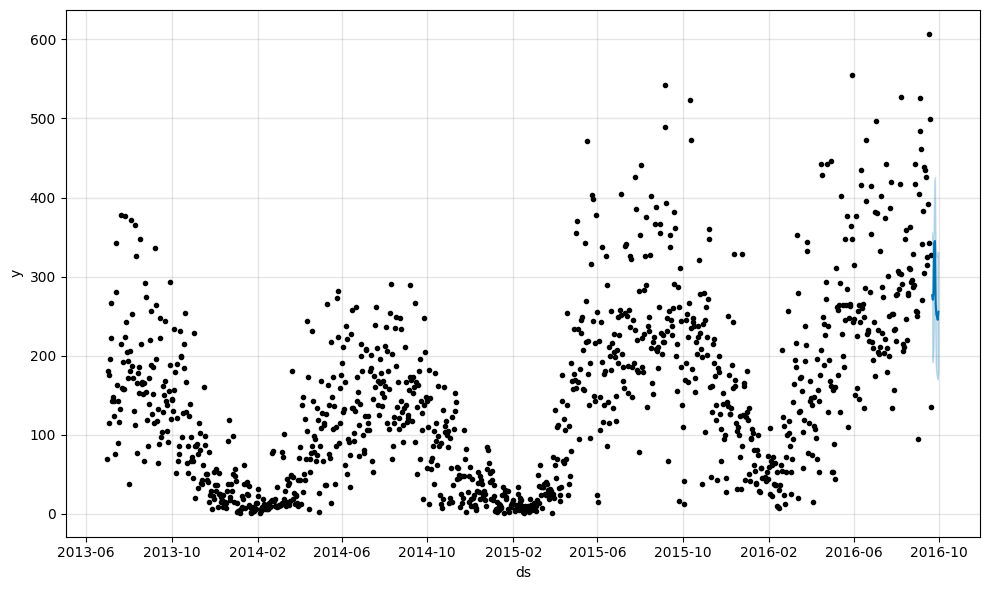

In [25]:
p.plot(forecast);

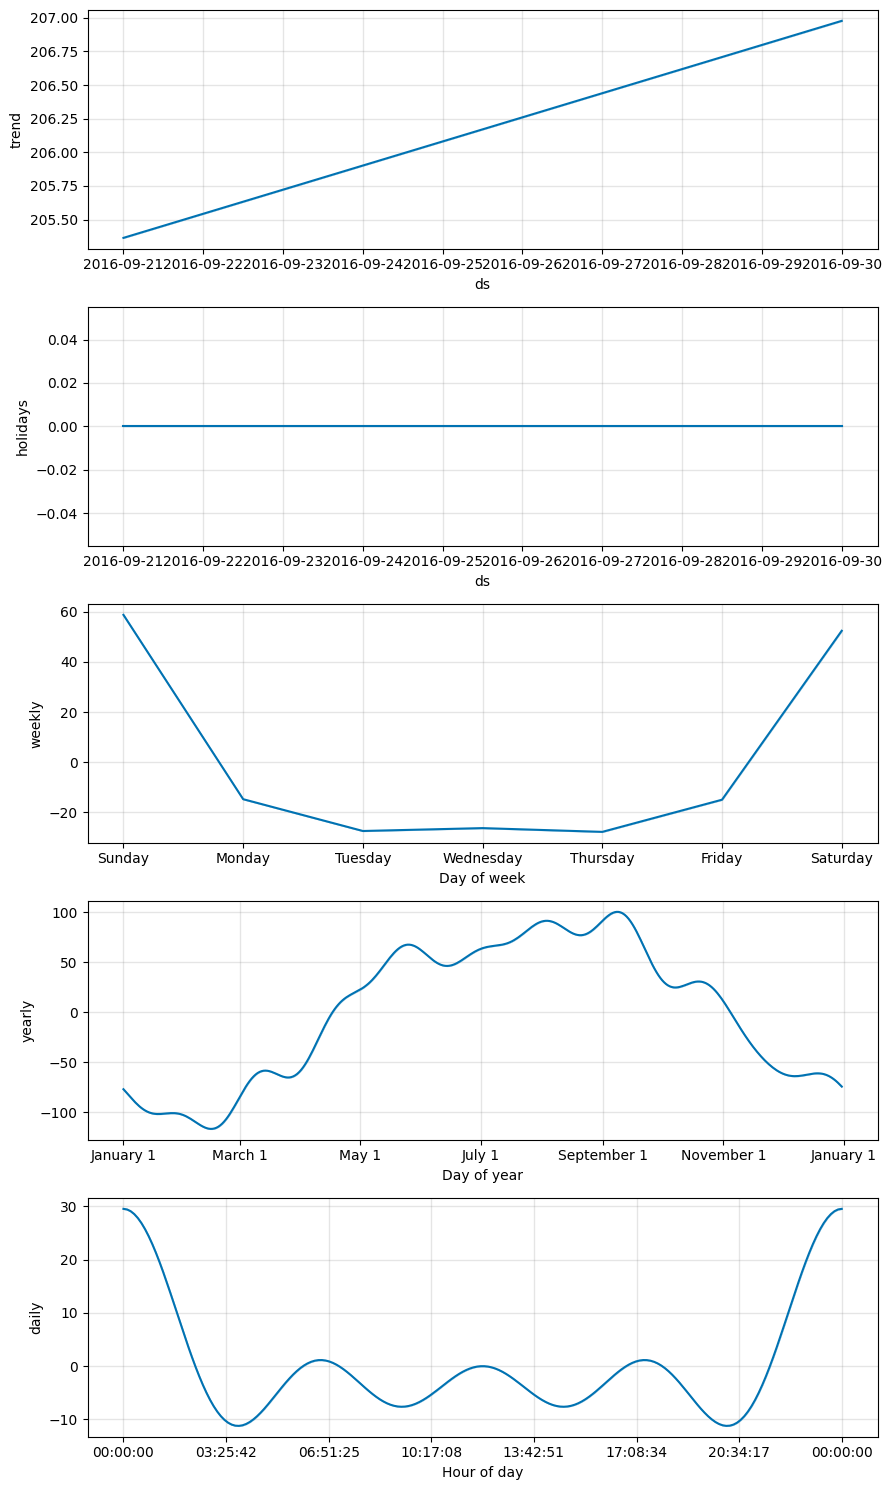

In [26]:
p.plot_components(forecast);

### Review Results

In [27]:
results = local_ts.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
results.iloc[-15:]

,ds,y,yhat,yhat_lower,yhat_upper
1162,2016-09-16,343,NaN,NaN,NaN
1163,2016-09-17,607,NaN,NaN,NaN
1164,2016-09-18,499,NaN,NaN,NaN
1165,2016-09-19,135,NaN,NaN,NaN
1166,2016-09-20,327,NaN,NaN,NaN
1167,2016-09-21,403,276.215619,195.776762,356.089939
1168,2016-09-22,351,270.607239,191.238681,349.273340
1169,2016-09-23,354,279.322979,205.972511,355.614311
1170,2016-09-24,399,342.629963,266.695908,419.429020
1171,2016-09-25,402,345.070498,267.003543,425.883585


In [28]:
results.dtypes

ds            date32[day][pyarrow]
y                            Int64
yhat                       float64
yhat_lower                 float64
yhat_upper                 float64
dtype: object

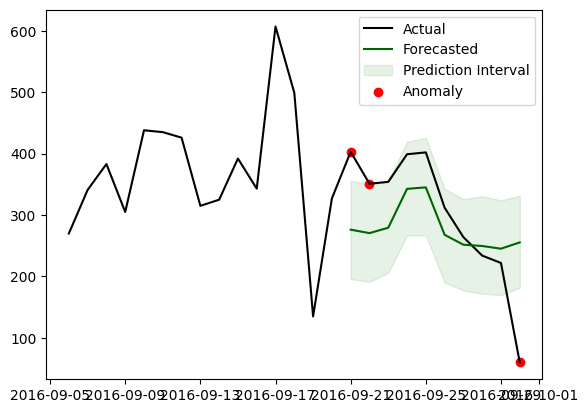

In [29]:
r_results = results[-25:]
fig, ax = plt.subplots()
ax.plot(r_results['ds'], r_results['y'], color = 'black', label = 'Actual')
ax.plot(r_results['ds'], r_results['yhat'], color = 'darkgreen', label = 'Forecasted')
ax.fill_between(r_results['ds'], r_results['yhat_lower'], r_results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
anomaly = r_results[(r_results['y'] < r_results['yhat_lower']) | (r_results['y'] > r_results['yhat_upper'])]
ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')

ax.legend(loc='best')

---
## Build Custom Prediction Routine

[Custom Prediction Routine](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines) - A custom container built by the Vertex AI SDK that assist with pre/post processing code without the need to setup an HTTP server.

Resources:
- [Class Predictor in SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.Predictor)
- [Class Predictor Interface (GitHub)](https://github.com/googleapis/python-aiplatform/blob/main/google/cloud/aiplatform/prediction/predictor.py)

Make a local folder for source code:

In [30]:
!mkdir -p {DIR}/SRC

Create a `requirements.txt` file with the required Python packages:

In [31]:
%%writefile {DIR}/SRC/requirements.txt
fastapi
uvicorn==0.17.6
pandas
google-cloud-aiplatform[prediction]>=1.16.0
pystan
prophet

Writing temp/online-prophet/SRC/requirements.txt


Create a `predictor.py` file with the prediction routine:

In [32]:
%%writefile {DIR}/SRC/predictor.py

# packages
from google.cloud.aiplatform.prediction.predictor import Predictor
from prophet import Prophet
import pandas as pd

def forecast(input_ts):
    
    read_ts = pd.DataFrame(input_ts, columns = ['ds', 'y'])
    read_ts['ds'] = pd.to_datetime(read_ts['ds'])
    
    p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(read_ts)
    
    future = p.make_future_dataframe(periods = 10, include_history = False)
    forecast = p.predict(future)
    
    forecast['ds'] = forecast['ds'].dt.strftime('%Y/%m/%d')
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_dict(orient = 'records')
    
    return forecast
    
class CprPredictor(Predictor):
    def __init__(self):
        return
    
    def load(self, artifacts_uri: str) -> None:
        # no model to load here, this example trains a model and returns predictions/forecast
        pass
        
    def predict(self, instances):
        
        instances = instances['instances']
        results = [forecast(instance) for instance in instances]
        
        # note that Vertex AI Endpoints expect the response to be named "predictions"
        return {"predictions": results}

Writing temp/online-prophet/SRC/predictor.py


---
## Format Data For Passing To/From Endpoint

### Examine Current Form: DataFrame

In [33]:
type(local_ts), local_ts.dtypes

(pandas.core.frame.DataFrame,
 ds    date32[day][pyarrow]
 y                    Int64
 dtype: object)

In [34]:
local_ts.head()

,ds,y
1628,2013-07-01,69
4063,2013-07-02,180
1227,2013-07-03,115
1354,2013-07-04,175
2435,2013-07-05,195


### Convert Data Types And Format As List

Data passed to Vertex AI Endpoints is expected in the format of ML features - like int, str, float.  Converting the dates to strings bypasses this restriction.  The custom predictor logic can first convert these strings back to dates.

Reference:
- [Format your input for online prediction](https://cloud.google.com/vertex-ai/docs/predictions/get-online-predictions)

In [35]:
input_ts = local_ts.copy()
input_ts['ds'] = local_ts['ds'].dt.strftime('%Y/%m/%d')

In [36]:
input_ts.head()

,ds,y
1628,2013/07/01,69
4063,2013/07/02,180
1227,2013/07/03,115
1354,2013/07/04,175
2435,2013/07/05,195


In [37]:
input_ts.dtypes

ds    string[pyarrow]
y               Int64
dtype: object

Format as List For Instances

In [38]:
input_ts = input_ts.values.tolist()

In [39]:
input_ts[0:2]

[['2013/07/01', 69], ['2013/07/02', 180]]

### Make DataFrame From Instance (List)

How to return the data to a dataframe:

In [40]:
read_ts = pd.DataFrame(input_ts, columns = ['ds', 'y'])

In [41]:
read_ts['ds'] = pd.to_datetime(read_ts['ds'])
read_ts.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [42]:
read_ts.head()

,ds,y
0,2013-07-01,69
1,2013-07-02,180
2,2013-07-03,115
3,2013-07-04,175
4,2013-07-05,195


---
## Run Custom Prediction Routine - Locally (In Notebook)

Build a local model from a custom predictor with [aiplatform.prediction.LocalModel.build_cpr_model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.LocalModel#google_cloud_aiplatform_prediction_LocalModel_build_cpr_model).

In [44]:
from google.cloud.aiplatform.prediction import LocalModel
import importlib
# load the local predictor class and call it CprPreditor:
predictor = importlib.import_module(f"temp.{EXPERIMENT}.SRC.predictor")

In [45]:
local_model = LocalModel.build_cpr_model(
    src_dir = f"{DIR}/SRC",
    output_image_uri = f"{REPOSITORY}/{SERIES}_{EXPERIMENT}",
    predictor = predictor.CprPredictor,
    requirements_path = f"{DIR}/SRC/requirements.txt",
)

/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


In [46]:
local_model.get_serving_container_spec()

image_uri: "us-central1-docker.pkg.dev/vertexaiproject-454121/vertexaiproject-454121/applied-forecasting_online-prophet"
predict_route: "/predict"
health_route: "/health"

### Try Forecasting With Local Model:

Depoy the model locally for testing with [aiplatform.prediction.LocalModel.deploy_to_local_endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.LocalModel#google_cloud_aiplatform_prediction_LocalModel_build_cpr_model):

In [47]:
with local_model.deploy_to_local_endpoint() as local_endpoint:
    predict_response = local_endpoint.predict(
        request = json.dumps(dict(instances = [input_ts])),
        headers = {"Content-Type": "application/json"}
    )
    health_check_response = local_endpoint.run_health_check()

Review the health check response:

In [48]:
health_check_response, health_check_response.content

(<Response [200]>, b'{}')

Review the predict response:

In [49]:
predict_response

<Response [200]>

In [50]:
print(predict_response.content)

b'{"predictions": [[{"ds": "2016/10/01", "yhat": 322.30221493274405, "yhat_lower": 244.70455592970725, "yhat_upper": 395.89050170316557}, {"ds": "2016/10/02", "yhat": 326.3697174681411, "yhat_lower": 249.06322036224788, "yhat_upper": 404.06468178147037}, {"ds": "2016/10/03", "yhat": 250.80974735029716, "yhat_lower": 175.79846044073284, "yhat_upper": 328.79465919340674}, {"ds": "2016/10/04", "yhat": 236.55864602490334, "yhat_lower": 160.09286752114414, "yhat_upper": 311.9621215257497}, {"ds": "2016/10/05", "yhat": 237.1625169599793, "yhat_lower": 154.2286340539636, "yhat_upper": 312.18178508081655}, {"ds": "2016/10/06", "yhat": 234.62912926318114, "yhat_lower": 160.22255228167424, "yhat_upper": 310.9525339306358}, {"ds": "2016/10/07", "yhat": 246.05895447188988, "yhat_lower": 174.13539522709885, "yhat_upper": 321.32117845265714}, {"ds": "2016/10/08", "yhat": 314.3915187414622, "yhat_lower": 236.97021664011388, "yhat_upper": 387.75614004839474}, {"ds": "2016/10/09", "yhat": 320.961692334

Transform the predict response to a dataframe of forecasted values:

In [51]:
forecast = [pd.DataFrame.from_dict(response) for response in json.loads(predict_response.content)['predictions']][0]
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2016/10/01,322.302215,244.704556,395.890502
1,2016/10/02,326.369717,249.063220,404.064682
2,2016/10/03,250.809747,175.798460,328.794659
3,2016/10/04,236.558646,160.092868,311.962122
4,2016/10/05,237.162517,154.228634,312.181785
5,2016/10/06,234.629129,160.222552,310.952534
6,2016/10/07,246.058954,174.135395,321.321178
7,2016/10/08,314.391519,236.970217,387.756140
8,2016/10/09,320.961692,242.899569,398.701385
9,2016/10/10,375.021119,300.998422,453.127353


In [52]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2016-10-01,322.302215,244.704556,395.890502
1,2016-10-02,326.369717,249.063220,404.064682
2,2016-10-03,250.809747,175.798460,328.794659
3,2016-10-04,236.558646,160.092868,311.962122
4,2016-10-05,237.162517,154.228634,312.181785
5,2016-10-06,234.629129,160.222552,310.952534
6,2016-10-07,246.058954,174.135395,321.321178
7,2016-10-08,314.391519,236.970217,387.756140
8,2016-10-09,320.961692,242.899569,398.701385
9,2016-10-10,375.021119,300.998422,453.127353


---
## Host Model To Vertex AI Online Endpoint

First, configure `gcloud` as the credential helper for Google Cloud Docker registries:

In [53]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
Docker configuration file updated.


### Create Docker Image Repository

Create an Artifact Registry Repository to hold Docker Images created by this notebook. First, check to see if it is already created by a previous run and retrieve it if it has. Otherwise, create!

Name the repository the same name as the `PROJECT_ID`.

In [54]:
docker_repo = None
for repo in ar_client.list_repositories(parent = f'projects/{PROJECT_ID}/locations/{REGION}'):
    if f'{PROJECT_ID}' == repo.name.split('/')[-1]:
        docker_repo = repo
        print(f'Retrieved existing repo: {docker_repo.name}')

if not docker_repo:
    operation = ar_client.create_repository(
        request = artifactregistry_v1.CreateRepositoryRequest(
            parent = f'projects/{PROJECT_ID}/locations/{REGION}',
            repository_id = f'{PROJECT_ID}',
            repository = artifactregistry_v1.Repository(
                description = f'A repository for the {EXPERIMENT} experiment that holds docker images.',
                name = f'{PROJECT_ID}',
                format_ = artifactregistry_v1.Repository.Format.DOCKER,
                labels = {'series': SERIES, 'experiment': EXPERIMENT}
            )
        )
    )
    print('Creating Repository ...')
    docker_repo = operation.result()
    print(f'Completed creating repo: {docker_repo.name}')

Creating Repository ...
Completed creating repo: projects/vertexaiproject-454121/locations/us-central1/repositories/vertexaiproject-454121


In [55]:
docker_repo.name, docker_repo.format_.name

('projects/vertexaiproject-454121/locations/us-central1/repositories/vertexaiproject-454121',
 'DOCKER')

In [56]:
REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{docker_repo.name.split('/')[-1]}"
REPOSITORY

'us-central1-docker.pkg.dev/vertexaiproject-454121/vertexaiproject-454121'

### Push model to Artifact Registry

The `local_model` was already given the repository address with parameter `output_image_uri` at definition above.  Use [aiplatform.prediction.LocalModel.push_image()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.LocalModel#google_cloud_aiplatform_prediction_LocalModel_push_image) to push the image from local to artifact registry:

In [57]:
local_model.push_image()

/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


In [58]:
print(f'Review the image in artifact registry here:\nhttps://console.cloud.google.com/artifacts/docker/{PROJECT_ID}/{REGION}/{PROJECT_ID}/{SERIES}_{EXPERIMENT}?project={PROJECT_ID}')

Review the image in artifact registry here:
https://console.cloud.google.com/artifacts/docker/vertexaiproject-454121/us-central1/vertexaiproject-454121/applied-forecasting_online-prophet?project=vertexaiproject-454121


### Register model in Vertex AI Model Registry

In [59]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    print('Loading model as new default version.')
    parent_model = modelmatch[0].resource_name
else:
    print('This is a new model, creating in model registry')
    parent_model = ''

This is a new model, creating in model registry


In [60]:
#model = modelmatch[0]

In [61]:
if upload_model:
    model = aiplatform.Model.upload(
        local_model = local_model,
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model =  parent_model,
        is_default_version = True,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}        
    )

Creating Model
Create Model backing LRO: projects/918019863602/locations/us-central1/models/model_applied-forecasting_online-prophet/operations/1659047150916468736
Model created. Resource name: projects/918019863602/locations/us-central1/models/model_applied-forecasting_online-prophet@1
To use this Model in another session:
model = aiplatform.Model('projects/918019863602/locations/us-central1/models/model_applied-forecasting_online-prophet@1')


In [62]:
model.version_id

'1'

### Create/Retrieve The Endpoint For This Series

Reference:
- [aiplatform.Endpoint](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [63]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")
    
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Creating Endpoint
Create Endpoint backing LRO: projects/918019863602/locations/us-central1/endpoints/6839653917580591104/operations/5203380057657049088
Endpoint created. Resource name: projects/918019863602/locations/us-central1/endpoints/6839653917580591104
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/918019863602/locations/us-central1/endpoints/6839653917580591104')
Endpoint Created: projects/918019863602/locations/us-central1/endpoints/6839653917580591104
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/6839653917580591104?project=vertexaiproject-454121


### Deploy model to Vertex AI Prediction Endpoint

Deploy with either:
- [aiplatform.Endpoint.deploy(model = model)](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)
- [aiplatform.Model.deploy(endpoint = endpoint)](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_deploy)

In [64]:
print(f'Deploying model with 100% of traffic...')
endpoint.deploy(
    model = model,
    deployed_model_display_name = model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 3,
    service_account = SERVICE_ACCOUNT
)

Deploying model with 100% of traffic...
Deploying Model projects/918019863602/locations/us-central1/models/model_applied-forecasting_online-prophet to Endpoint : projects/918019863602/locations/us-central1/endpoints/6839653917580591104
Deploy Endpoint model backing LRO: projects/918019863602/locations/us-central1/endpoints/6839653917580591104/operations/4014429756031238144
Endpoint model deployed. Resource name: projects/918019863602/locations/us-central1/endpoints/6839653917580591104


### Remove Deployed Models without Traffic

In [65]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model applied-forecasting_online-prophet with version 1 has traffic = 100


---
## Get Online Predictions

### A Single Instance

In [66]:
local_ts = df[(df['start_station_name'] == stations[0])][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds']).to_pandas()

In [67]:
input_ts = local_ts[0:-10].copy()
input_ts['ds'] = local_ts['ds'].dt.strftime('%Y/%m/%d')
input_ts = input_ts.values.tolist()

In [68]:
prediction = endpoint.predict(instances = [input_ts])

In [69]:
prediction.predictions[0][0:2]

[{'yhat_upper': 351.8618044656255,
  'yhat_lower': 199.771170137535,
  'ds': '2016/09/21',
  'yhat': 276.2156187001162},
 {'ds': '2016/09/22',
  'yhat_lower': 198.1392611198226,
  'yhat': 270.6072387211392,
  'yhat_upper': 345.0554340693706}]

In [70]:
forecast = pd.DataFrame.from_dict(prediction.predictions[0])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast

,yhat_upper,yhat_lower,ds,yhat
0,351.861804,199.771170,2016-09-21,276.215619
1,345.055434,198.139261,2016-09-22,270.607239
2,352.322647,208.149430,2016-09-23,279.322979
3,416.965383,264.917255,2016-09-24,342.629963
4,424.097587,264.859681,2016-09-25,345.070498
5,345.281970,188.320484,2016-09-26,267.875081
6,326.799253,174.418702,2016-09-27,251.707391
7,328.061798,173.162480,2016-09-28,249.636276
8,322.749295,168.044461,2016-09-29,245.229627
9,334.388052,177.270943,2016-09-30,255.476311


In [71]:
results = local_ts[-25:].merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
results.iloc[-15:]

,ds,y,yhat,yhat_lower,yhat_upper
10,2016-09-16,343,NaN,NaN,NaN
11,2016-09-17,607,NaN,NaN,NaN
12,2016-09-18,499,NaN,NaN,NaN
13,2016-09-19,135,NaN,NaN,NaN
14,2016-09-20,327,NaN,NaN,NaN
15,2016-09-21,403,276.215619,199.771170,351.861804
16,2016-09-22,351,270.607239,198.139261,345.055434
17,2016-09-23,354,279.322979,208.149430,352.322647
18,2016-09-24,399,342.629963,264.917255,416.965383
19,2016-09-25,402,345.070498,264.859681,424.097587


In [72]:
anomaly = results[(results['y'] < results['yhat_lower']) | (results['y'] > results['yhat_upper'])]

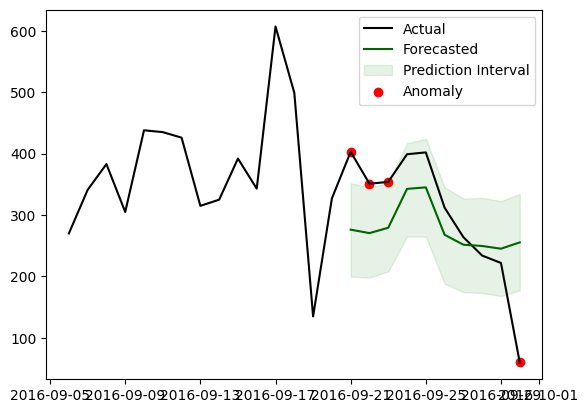

In [73]:
fig, ax = plt.subplots()
ax.plot(results['ds'], results['y'], color = 'black', label = 'Actual')
ax.plot(results['ds'], results['yhat'], color = 'darkgreen', label = 'Forecasted')
ax.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')
ax.legend(loc='best')
fig.show()

### Multiple Instances - Different Time Series

In [74]:
stations

['Central Park S & 6 Ave',
 'W 82 St & Central Park West',
 'Central Park West & W 76 St',
 'Grand Army Plaza & Central Park S',
 'Central Park West & W 72 St',
 'Central Park West & W 85 St',
 'Central Park West & W 100 St',
 'Central Park W & W 96 St',
 'Central Park West & W 102 St',
 'W 106 St & Central Park West',
 'Central Park North & Adam Clayton Powell Blvd',
 'Central Park West & W 68 St']

In [75]:
local_ts = [df[(df['start_station_name'] == station) & (df['splits'] != 'TEST')][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds']).to_pandas() for station in stations[1:3]]

In [76]:
input_ts = [lts[0:-10].copy() for lts in local_ts]
for i in input_ts:
    i['ds'] = i['ds'].dt.strftime('%Y/%m/%d')
input_ts = [i.values.tolist() for i in input_ts]

In [77]:
predictions = endpoint.predict(instances = input_ts)

In [78]:
forecasts = [pd.DataFrame.from_dict(prediction) for prediction in predictions.predictions]

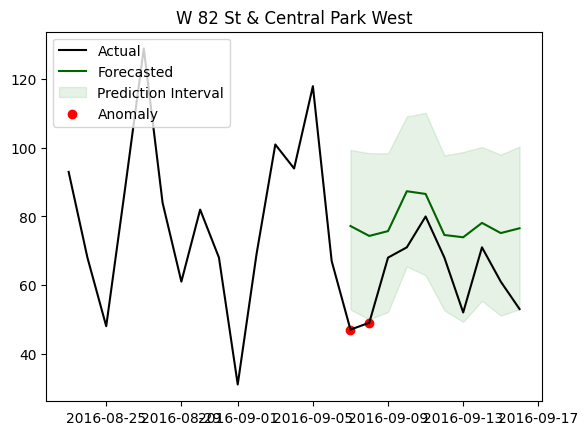

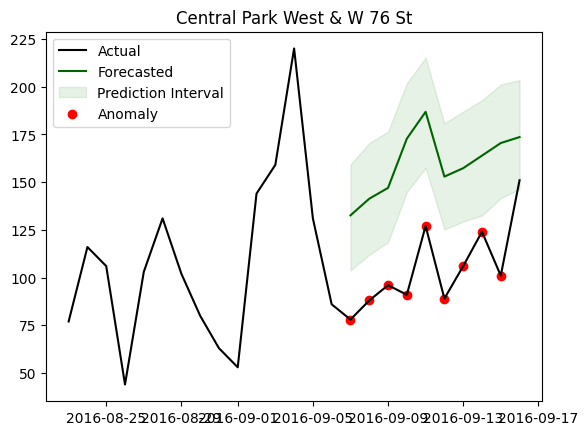

In [79]:
for i in range(len(input_ts)):
    forecasts[i]['ds'] = pd.to_datetime(forecasts[i]['ds'])
    results = local_ts[i][-25:].merge(forecasts[i][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[i][['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
    anomaly = results[(results['y'] < results['yhat_lower']) | (results['y'] > results['yhat_upper'])]
    fig, ax = plt.subplots()
    ax.set_title(f'{stations[i+1]}')
    ax.plot(results['ds'], results['y'], color = 'black', label = 'Actual')
    ax.plot(results['ds'], results['yhat'], color = 'darkgreen', label = 'Forecasted')
    ax.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
    ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')
    ax.legend(loc='best')
    fig.show()

### Multiple Instances - Different history lengths

In [80]:
local_ts = df[(df['start_station_name'] == stations[0])][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds']).to_pandas()

In [81]:
input_ts = local_ts[0:-10].copy()
input_ts['ds'] = local_ts['ds'].dt.strftime('%Y/%m/%d')
input_ts = input_ts.values.tolist()

In [82]:
len(input_ts), input_ts[0]

(1167, ['2013/07/01', 69])

In [83]:
history_sizes = [('full', 0), ('month', 30), ('quarter', 90), ('half', 180), ('year', 365), ('18 month', 540), ('2 year', 730)]

In [84]:
predictions = endpoint.predict(instances = [input_ts[-1*h[1]:] for h in history_sizes])

In [85]:
forecasts = [pd.DataFrame.from_dict(prediction) for prediction in predictions.predictions]

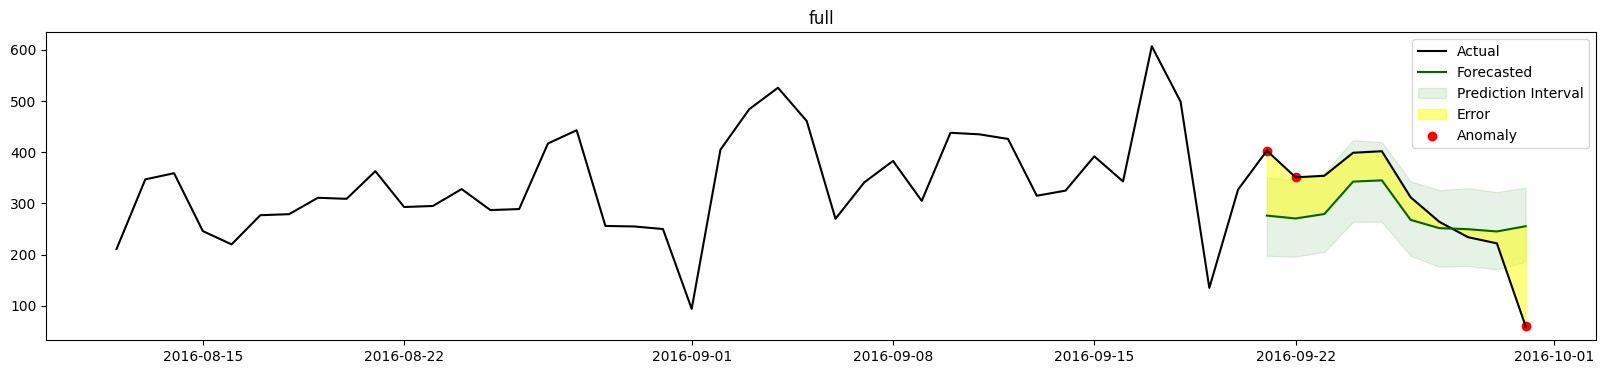

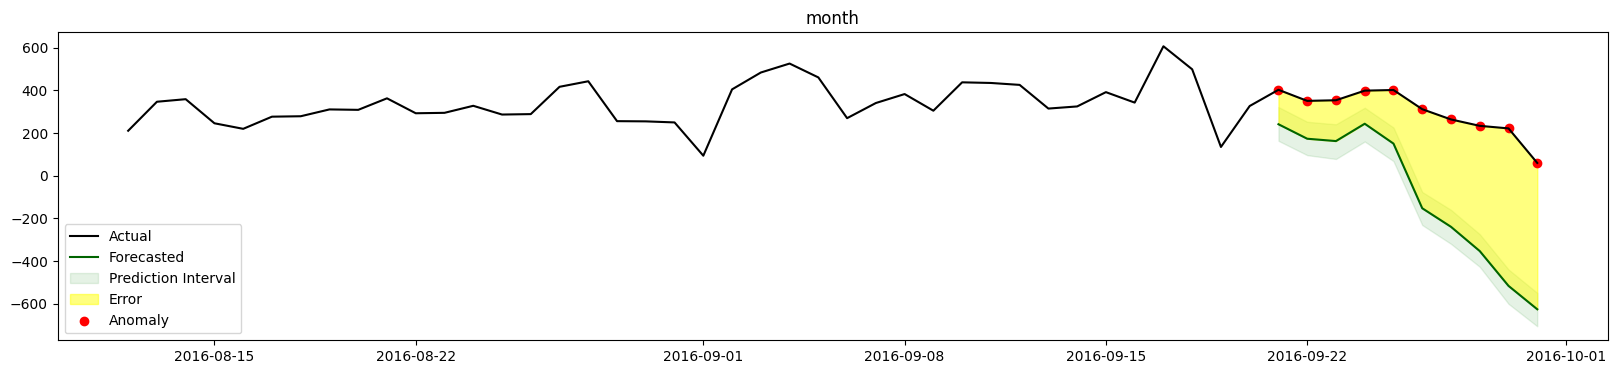

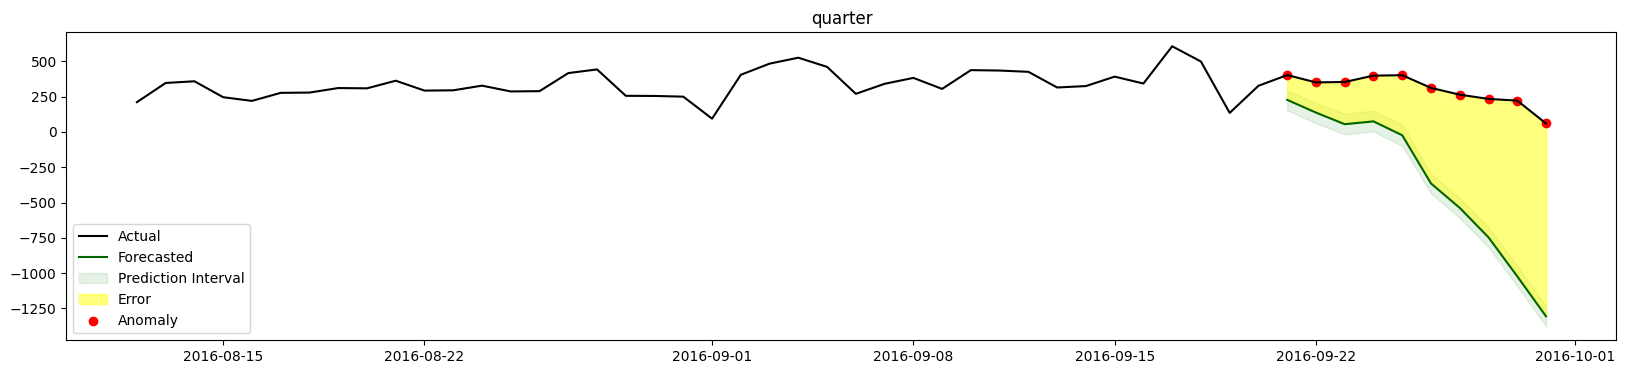

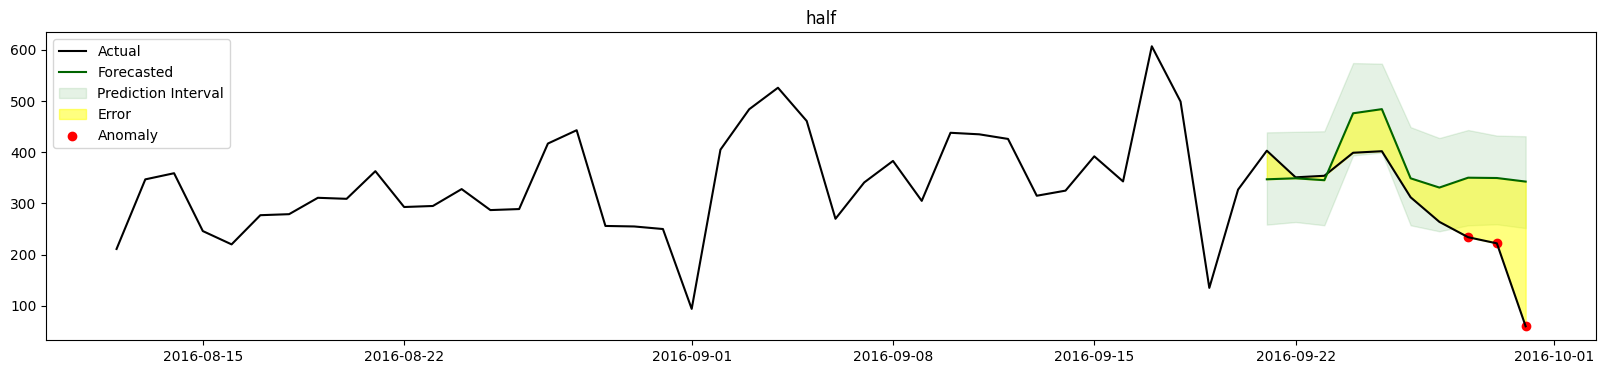

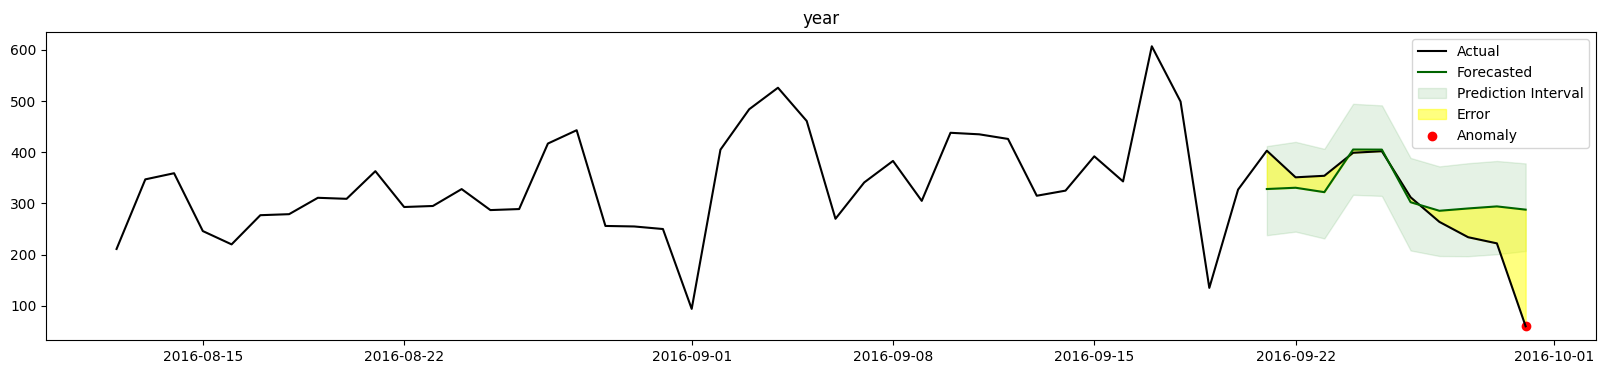

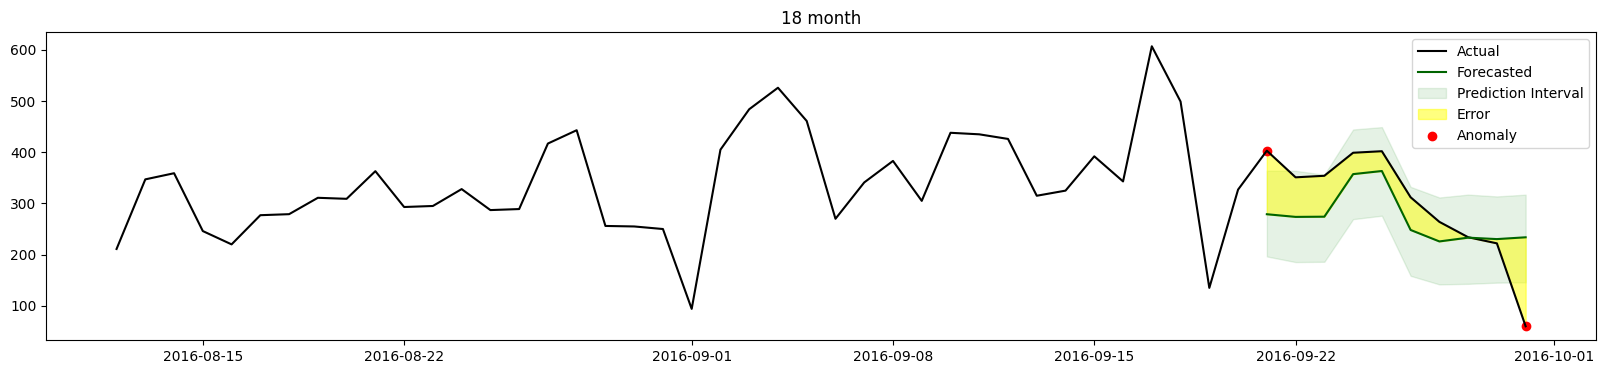

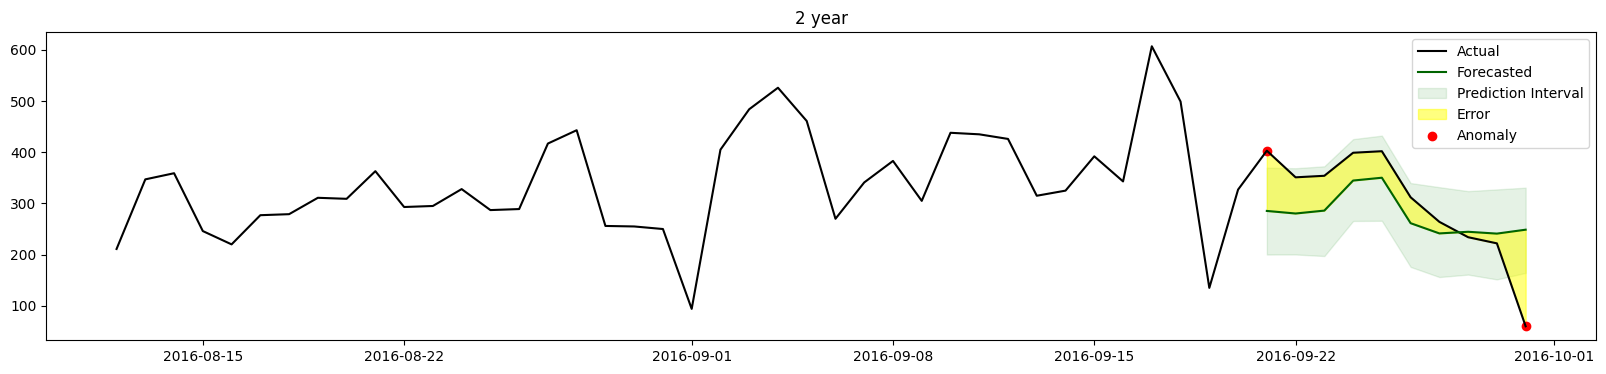

In [86]:
for i in range(len(forecasts)):
    forecasts[i]['ds'] = pd.to_datetime(forecasts[i]['ds'])
    results = local_ts[-50:].merge(forecasts[i][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
    anomaly = results[(results['y'] < results['yhat_lower']) | (results['y'] > results['yhat_upper'])]
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.set_title(f'{history_sizes[i][0]}')
    ax.plot(results['ds'], results['y'], color = 'black', label = 'Actual')
    ax.plot(results['ds'], results['yhat'], color = 'darkgreen', label = 'Forecasted')
    ax.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
    ax.fill_between(results['ds'], results['y'].astype('float'), results['yhat'], color = 'yellow', alpha = .5, label = 'Error')
    ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')
    ax.legend(loc='best')
    fig.show()

The screenshots below show the endpoint performance and resources values during the tests above.  Notice the endpoint scales from 1 replica to 3 (the max set at creation above).  Also, as the endpoint scales the latency drops!

---
## Remove Resources

The endpoint will continue to run unless it is stopped:

In [ ]:
#endpoint.delete(force = True)